In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import seaborn as sns

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
var2_train= ohe.fit_transform(train[['var2']]).toarray()
feature_labels_train = ohe.categories_

train_var2_encoded = pd.DataFrame(var2_train, columns = feature_labels_train)
train_cleaned = pd.concat([train, train_var2_encoded], axis = 1)
train_cleaned = train_cleaned.drop(columns=['ID', 'var2'])
train_cleaned['datetime'] = pd.to_datetime(train_cleaned['datetime'])
train_cleaned = train_cleaned.set_index(['datetime'])

ohe = OneHotEncoder()
var2_test= ohe.fit_transform(test[['var2']]).toarray()
feature_labels_test = ohe.categories_

test_var2_encoded = pd.DataFrame(var2_test, columns = feature_labels_test)
test_cleaned = pd.concat([test, test_var2_encoded], axis = 1)
test_cleaned = test_cleaned.drop(columns=['ID', 'var2'])
test_cleaned['datetime'] = pd.to_datetime(test_cleaned['datetime'])
test_cleaned = test_cleaned.set_index(['datetime'])

In [3]:
train_cleaned.columns = ['temperature', 'var1', 'pressure', 'windspeed', 'electricity_consumption', 'Var_A', 'Var_B', 'Var_C']
test_cleaned.columns = ['temperature', 'var1', 'pressure', 'windspeed', 'Var_A', 'Var_B', 'Var_C']

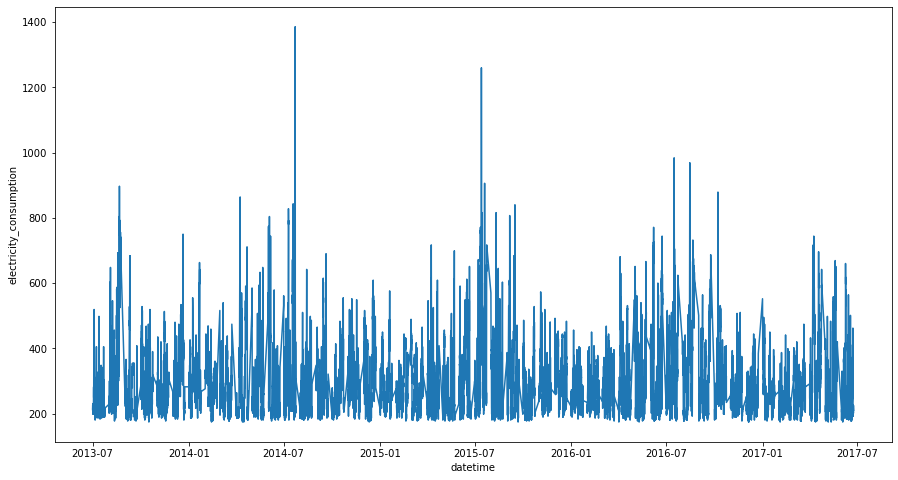

In [4]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(data = train_cleaned['2013-07-01':'2017-07-01'],
                  x = train_cleaned['2013-07-01':'2017-07-01'].index,
                  y=train_cleaned['2013-07-01':'2017-07-01'].electricity_consumption)

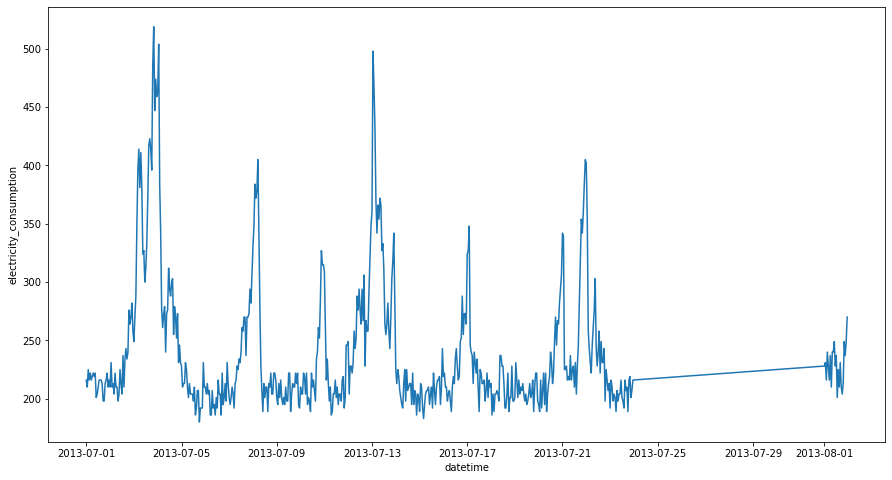

In [5]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(data = train_cleaned['2013-07-01':'2013-08-01'],
                  x = train_cleaned['2013-07-01':'2013-08-01'].index,
                  y=train_cleaned['2013-07-01':'2013-08-01'].electricity_consumption)

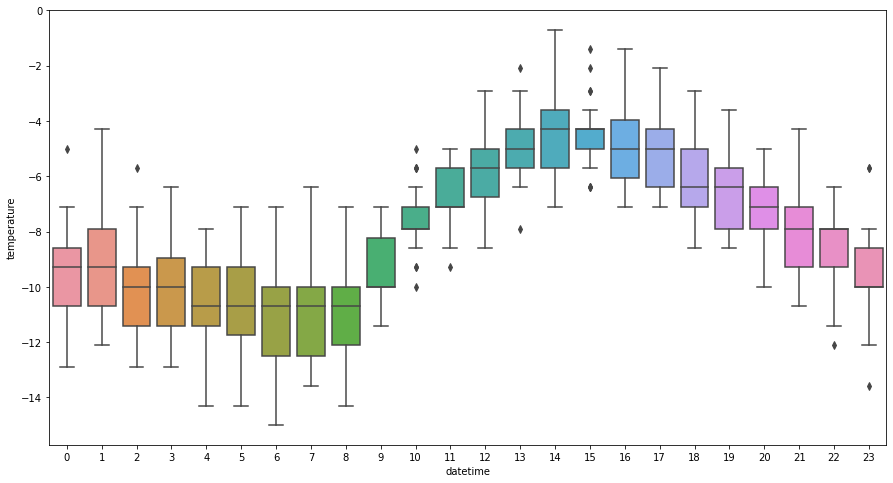

In [6]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x=train_cleaned['2013-07-01':'2013-07-23'].index.hour, y=train_cleaned['2013-07-01':'2013-07-23'].temperature)

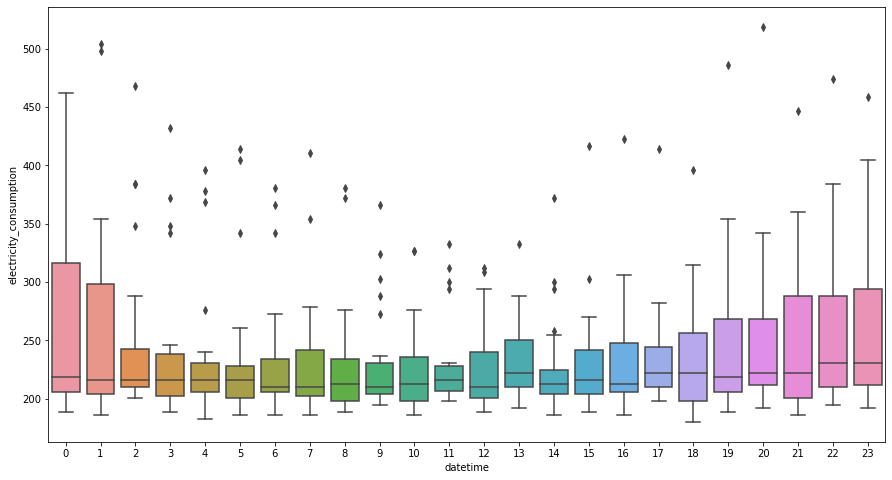

In [7]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x=train_cleaned['2013-07-01':'2013-07-23'].index.hour, y=train_cleaned['2013-07-01':'2013-07-23'].electricity_consumption)

In [8]:
train_cleaned['datetime'] = train_cleaned.index
test_cleaned['datetime'] = test_cleaned.index

train_cleaned['year'] = train_cleaned['datetime'].dt.year
train_cleaned['month'] = train_cleaned['datetime'].dt.month
train_cleaned['day'] = train_cleaned['datetime'].dt.day
train_cleaned['hour'] = train_cleaned['datetime'].dt.hour

test_cleaned['year'] = test_cleaned['datetime'].dt.year
test_cleaned['month'] = test_cleaned['datetime'].dt.month
test_cleaned['day'] = test_cleaned['datetime'].dt.day
test_cleaned['hour'] = test_cleaned['datetime'].dt.hour

In [9]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import math

xgb = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=25)

cv = TimeSeriesSplit(n_splits = 5)

for train, test in cv.split(train_cleaned):
    train_data =  train_cleaned.iloc[train]
    test_data = train_cleaned.iloc[test]
    X_train = train_data.drop(["datetime", "electricity_consumption"], axis = 1)
    Y_train = train_data["electricity_consumption"]
    X_test = test_data.drop(["datetime", "electricity_consumption"], axis = 1)
    Y_test = test_data["electricity_consumption"]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    xgb.fit(X_train, Y_train)
    preds = xgb.predict(X_test)
    
    print("R2_score", r2_score(Y_test, preds), "mean_squared_error", math.sqrt(mean_squared_error(Y_test, preds)))

R2_score -0.08306322348961426 mean_squared_error 124.05139175196757
R2_score 0.23789465730944492 mean_squared_error 77.42499234255295
R2_score 0.3212967341626505 mean_squared_error 94.81248834172936
R2_score 0.3030226476116581 mean_squared_error 99.03440689480767
R2_score 0.33659725625753467 mean_squared_error 76.88595814057288


In [10]:
X_test = scaler.transform(test_cleaned.drop(['datetime'], axis = 1))
test_cleaned['electricity_consumption'] = xgb.predict(X_test)

In [11]:
combinded_df = pd.concat([train_cleaned, test_cleaned])

In [12]:
plot_data = combinded_df[(combinded_df["month"] == 7) & (combinded_df["year"] == 2013)]

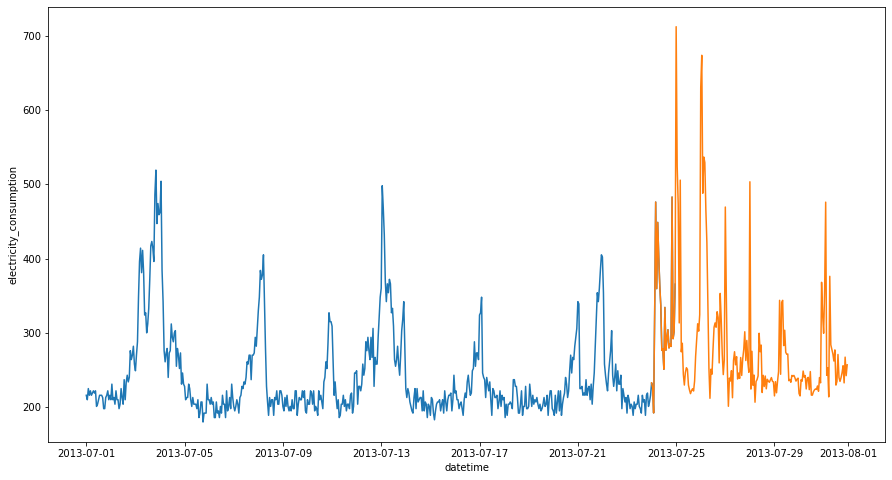

In [13]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(data = plot_data['2013-07-01':'2013-07-24'],
                  x = plot_data['2013-07-01':'2013-07-24'].index,
                  y=plot_data['2013-07-01':'2013-07-24'].electricity_consumption)
ax = sns.lineplot(data = plot_data['2013-07-24':'2013-07-31'],
                  x = plot_data['2013-07-24':'2013-07-31'].index,
                  y=plot_data['2013-07-24':'2013-07-31'].electricity_consumption)

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
cv = TimeSeriesSplit(n_splits = 5)
scaler = StandardScaler()

for train, test in cv.split(train_cleaned):
    train_data =  train_cleaned.iloc[train]
    test_data = train_cleaned.iloc[test]
    X_train = train_data.drop(["datetime", "electricity_consumption"], axis = 1)
    Y_train = train_data["electricity_consumption"]
    X_test = test_data.drop(["datetime", "electricity_consumption"], axis = 1)
    Y_test = test_data["electricity_consumption"]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    gbr.fit(X_train, Y_train)
    preds = gbr.predict(X_test)
    
    print("R2_score", r2_score(Y_test, preds), "mean_squared_error", math.sqrt(mean_squared_error(Y_test, preds)))

R2_score 0.08232536228433085 mean_squared_error 114.18764100365273
R2_score 0.3453303255890149 mean_squared_error 71.76038828838078
R2_score 0.2877074952323472 mean_squared_error 97.13030723325859
R2_score 0.28957163035623057 mean_squared_error 99.98547628972958
R2_score 0.34350462445594976 mean_squared_error 76.48464138751078


In [15]:
X_test = scaler.transform(test_cleaned.drop(["datetime", "electricity_consumption"], axis = 1))
test_cleaned['electricity_consumption'] = gbr.predict(X_test)

In [16]:
combinded_df = pd.concat([train_cleaned, test_cleaned])

In [17]:
plot_data = combinded_df[(combinded_df["month"] == 7) & (combinded_df["year"] == 2013)]

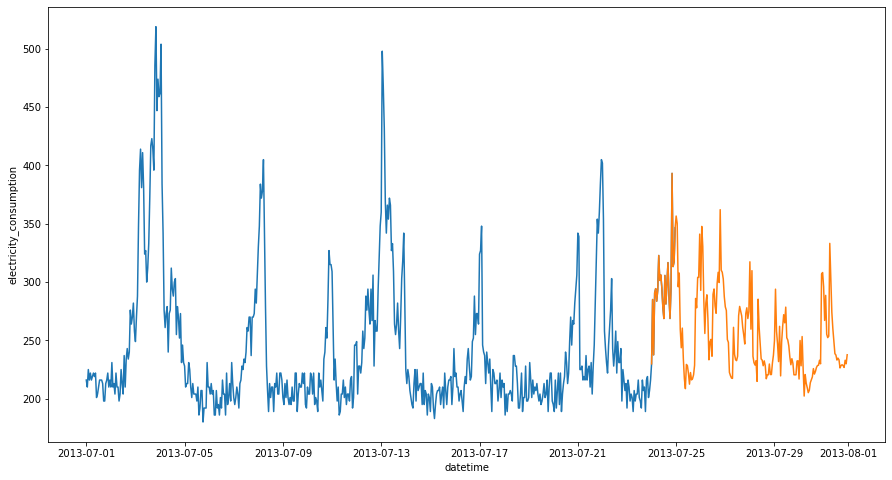

In [18]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(data = plot_data['2013-07-01':'2013-07-24'],
                  x = plot_data['2013-07-01':'2013-07-24'].index,
                  y=plot_data['2013-07-01':'2013-07-24'].electricity_consumption)
ax = sns.lineplot(data = plot_data['2013-07-24':'2013-07-31'],
                  x = plot_data['2013-07-24':'2013-07-31'].index,
                  y=plot_data['2013-07-24':'2013-07-31'].electricity_consumption)

In [27]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=20)
cv = TimeSeriesSplit(n_splits = 5)
scaler = StandardScaler()

for train, test in cv.split(train_cleaned):
    train_data =  train_cleaned.iloc[train]
    test_data = train_cleaned.iloc[test]
    X_train = train_data.drop(["datetime", "electricity_consumption"], axis = 1)
    Y_train = train_data["electricity_consumption"]
    X_test = test_data.drop(["datetime", "electricity_consumption"], axis = 1)
    Y_test = test_data["electricity_consumption"]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    knn.fit(X_train, Y_train)
    preds = knn.predict(X_test)
    
    print("R2_score", r2_score(Y_test, preds), "mean_squared_error", math.sqrt(mean_squared_error(Y_test, preds)))

R2_score 0.028503143521544927 mean_squared_error 117.48852088209512
R2_score 0.09856065972255057 mean_squared_error 84.20578360698775
R2_score 0.19653886369232343 mean_squared_error 103.15921117313823
R2_score 0.3015499053658641 mean_squared_error 99.13898359855119
R2_score 0.018432554084511832 mean_squared_error 93.52300922273666


In [28]:
X_test = scaler.transform(test_cleaned.drop(["datetime", "electricity_consumption"], axis = 1))
test_cleaned['electricity_consumption'] = knn.predict(X_test)

In [ ]:
combinded_df = pd.concat([train_cleaned, test_cleaned])

In [ ]:
plot_data = combinded_df[(combinded_df["month"] == 7) & (combinded_df["year"] == 2013)]

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(data = plot_data['2013-07-01':'2013-07-24'],
                  x = plot_data['2013-07-01':'2013-07-24'].index,
                  y=plot_data['2013-07-01':'2013-07-24'].electricity_consumption)
ax = sns.lineplot(data = plot_data['2013-07-24':'2013-07-31'],
                  x = plot_data['2013-07-24':'2013-07-31'].index,
                  y=plot_data['2013-07-24':'2013-07-31'].electricity_consumption)